<a href="https://colab.research.google.com/github/MariaExtrella/TFM/blob/main/03_Aproximaci%C3%B3n_priorizando_A2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import joblib
import json

In [2]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.base import clone

In [3]:
import warnings
warnings.filterwarnings('ignore')

# **Funciones de carga y limpieza del dataset de cada Arduino**

**Cargar los datos de los 3 ficheros de Arduinos**

In [4]:
# Función para cargar datos de Arduino
def cargar_arduino(filepath, nombre_arduino):
    # Leer todo el fichero como texto para limpiarlo
    df = pd.read_csv(
        filepath,
        sep=';',
        header=None,
        dtype=str,
        encoding='latin-1',
        on_bad_lines='skip'
    )

    # Buscar filas que contienen la cabecera real
    mask_header = df[0].str.contains('FECHA', na=False)

    # Obtener los nombres de columnas de la primera cabecera encontrada
    if mask_header.any():
        header_idx = mask_header.idxmax()
        column_names = df.iloc[header_idx].tolist()
    else:
        raise ValueError(f"No se encontró cabecera válida en {filepath}")

    # Intentar convertir a datetime, lo que no sea fecha queda como NaT
    df['datetime'] = pd.to_datetime(df[0], format='%d/%m/%Y %H:%M:%S', errors='coerce')

    # Quedarse solo con las filas que tienen fecha válida
    df_clean = df[df['datetime'].notna()].copy()

    # Eliminar columna 0 (fecha original) y quedarnos con las numéricas
    df_clean = df_clean.drop(columns=[0])

    # Convertir decimales (coma -> punto) en columnas numéricas (no datetime)
    for col in df_clean.columns:
        if col != 'datetime':
            df_clean[col] = df_clean[col].str.replace(',', '.').astype(float)

    # Asignar nombres de columnas (sin la fecha, que ya es 'datetime')
    cols_numericas = column_names[1:]  # Quitar 'FECHA y HORA'
    df_clean.columns = cols_numericas + ['datetime']

    # Añadir sufijo para identificar el arduino (excepto datetime)
    df_clean.columns = [f"{col}_{nombre_arduino}" if col != 'datetime' else col
                        for col in df_clean.columns]

    # Quedarse con el primer registro de cada timestamp
    df_clean = df_clean.drop_duplicates(subset='datetime', keep='first')

    return df_clean

In [5]:
ruta_base = 'https://raw.githubusercontent.com/MariaExtrella/TFM/refs/heads/main/'

# Cargar cada dataset
df_a1 = cargar_arduino(os.path.join(ruta_base, 'arduino1.csv'), 'A1')
df_a2 = cargar_arduino(os.path.join(ruta_base, 'arduino2.csv'), 'A2')
df_a3 = cargar_arduino(os.path.join(ruta_base, 'arduino3.csv'), 'A3')


**Eliminar outliers de los Arduinos**

In [6]:
# Eliminar radiación gamma con valores imposibles (>500 parece error)
df_a1.loc[df_a1['GDK101: Radi 10.2_A1'] > 500, 'GDK101: Radi 10.2_A1'] = np.nan
df_a2.loc[df_a2['GDK101: Radi 10.2_A2'] > 500, 'GDK101: Radi 10.2_A2'] = np.nan
df_a3.loc[df_a3['GDK101: Radi 10.2_A3'] > 500, 'GDK101: Radi 10.2_A3'] = np.nan

# Eliminar filas en las que coinciden valores de temperatura, humedad y CO2 a 0 en A2
cols_scd30_a2 = ['SCD30: Temp._A2', 'SCD30: Humedad r._A2', 'SCD30: CO2_A2']
ceros_a2 = (df_a2[cols_scd30_a2] == 0).any(axis=1)
df_a2.loc[ceros_a2, cols_scd30_a2] = np.nan

# Eliminar solo CO2 cuando es cero en Arduino 3
df_a3.loc[df_a3['SCD30: CO2_A3'] == 0, 'SCD30: CO2_A3'] = np.nan

# Aplicar la regla PM1.0 ≤ PM2.5 ≤ PM10
# Definir condición de registros INVÁLIDOS (violan la regla)
invalidos_a1 = (df_a1['PMS5003: PM 1.0_A1'] > df_a1['PMS5003: PM 2.5_A1']) | \
               (df_a1['PMS5003: PM 2.5_A1'] > df_a1['PMS5003: PM 10_A1'])

invalidos_a2 = (df_a2['PMS5003: PM 1.0_A2'] > df_a2['PMS5003: PM 2.5_A2']) | \
               (df_a2['PMS5003: PM 2.5_A2'] > df_a2['PMS5003: PM 10_A2'])

invalidos_a3 = (df_a3['PMS5003: PM 1.0_A3'] > df_a3['PMS5003: PM 2.5_A3']) | \
               (df_a3['PMS5003: PM 2.5_A3'] > df_a3['PMS5003: PM 10_A3'])

# Marcar como NaN las columnas de PM
df_a1.loc[invalidos_a1, ['PMS5003: PM 1.0_A1', 'PMS5003: PM 2.5_A1', 'PMS5003: PM 10_A1']] = np.nan
df_a2.loc[invalidos_a2, ['PMS5003: PM 1.0_A2', 'PMS5003: PM 2.5_A2', 'PMS5003: PM 10_A2']] = np.nan
df_a3.loc[invalidos_a3, ['PMS5003: PM 1.0_A3', 'PMS5003: PM 2.5_A3', 'PMS5003: PM 10_A3']] = np.nan



In [7]:
# Ordenar los datos de los Arduinos por fecha
df_a1 = df_a1.sort_values('datetime').reset_index(drop=True)
df_a2 = df_a2.sort_values('datetime').reset_index(drop=True)
df_a3 = df_a3.sort_values('datetime').reset_index(drop=True)

In [8]:
# Antes del resample, comprobar frecuencia original
print("Intervalo entre mediciones A2:")
print(df_a2['datetime'].diff().describe())


Intervalo entre mediciones A2:
count                         5208
mean     0 days 00:30:41.432987711
std      0 days 15:07:33.864383239
min                0 days 00:01:58
25%                0 days 00:09:23
50%                0 days 00:09:28
75%                0 days 00:09:36
max               41 days 19:09:46
Name: datetime, dtype: object


**Apilar los datos de los Arduions dando prioridad al a2**

In [9]:
def combinar_arduinos_prioridad(df_a1, df_a2, df_a3, prioridad=['A2', 'A1', 'A3']):
    """
    Combina datos de Arduinos dando prioridad al especificado.
    """

    # Función para quitar sufijo del Arduino
    def normalizar_columnas(df, sufijo):
        df = df.copy()
        nuevas_cols = {}
        for col in df.columns:
            if col == 'datetime':
                nuevas_cols[col] = col
            else:
                # Quitar el sufijo _A1, _A2, _A3
                nuevo_nombre = col.replace(f'_{sufijo}', '')
                nuevas_cols[col] = nuevo_nombre
        return df.rename(columns=nuevas_cols)

    # Normalizar nombres de columnas
    df_a1_norm = normalizar_columnas(df_a1, 'A1')
    df_a2_norm = normalizar_columnas(df_a2, 'A2')
    df_a3_norm = normalizar_columnas(df_a3, 'A3')

    # Resample
    dfs = {
        'A1': df_a1_norm.set_index('datetime').resample('10min').mean(),
        'A2': df_a2_norm.set_index('datetime').resample('10min').mean(),
        'A3': df_a3_norm.set_index('datetime').resample('10min').mean()
    }

    # Obtener todos los timestamps únicos
    all_timestamps = dfs['A1'].index.union(dfs['A2'].index).union(dfs['A3'].index)

    # Columnas numéricas
    cols_numericas = list(dfs['A1'].columns)

    # Crear DataFrame resultado
    resultado = pd.DataFrame(index=all_timestamps)
    for col in cols_numericas:
        resultado[col] = np.nan
    resultado['arduino'] = None

    # Para cada timestamp, usar el Arduino con mayor prioridad que tenga datos
    for ts in all_timestamps:
        for arduino in prioridad:
            if ts in dfs[arduino].index:
                row = dfs[arduino].loc[ts]
                if not row.isna().all():
                    for col in cols_numericas:
                        resultado.loc[ts, col] = row[col]
                    resultado.loc[ts, 'arduino'] = arduino
                    break

    # Convertir a numérico
    for col in cols_numericas:
        resultado[col] = pd.to_numeric(resultado[col], errors='coerce')

    # Eliminar filas completamente vacías
    resultado = resultado.dropna(subset=cols_numericas, how='all')

    return resultado

# Aplicar con prioridad A2 > A1 > A3
df_arduinos_prioridad = combinar_arduinos_prioridad(df_a1, df_a2, df_a3, prioridad=['A2', 'A1', 'A3'])

print(f"Registros totales: {len(df_arduinos_prioridad)}")
print(f"\nOrigen de datos:")
print(df_arduinos_prioridad['arduino'].value_counts())
print(f"\nColumnas: {df_arduinos_prioridad.columns.tolist()}")

Registros totales: 7749

Origen de datos:
arduino
A2    4683
A3    1890
A1    1176
Name: count, dtype: int64

Columnas: ['PMS5003: PM 1.0', 'PMS5003: PM 2.5', 'PMS5003: PM 10', 'DHT22: Temp.', 'DHT22: Humedad r.', 'MQ-7: CO', 'SHT85: Temp.', 'SHT85: Humedad r.', 'GDK101: Radi 10.2', 'SCD30: Temp.', 'SCD30: Humedad r.', 'SCD30: CO2', 'arduino']


In [10]:
df_arduinos_prioridad.shape

(7749, 13)

In [11]:
# Ver cuántos valores perdidos quedan en el dataset completo
print(df_arduinos_prioridad.isna().sum())

PMS5003: PM 1.0        1
PMS5003: PM 2.5        1
PMS5003: PM 10         1
DHT22: Temp.           0
DHT22: Humedad r.      0
MQ-7: CO               0
SHT85: Temp.           0
SHT85: Humedad r.      0
GDK101: Radi 10.2    132
SCD30: Temp.          64
SCD30: Humedad r.     64
SCD30: CO2           330
arduino                0
dtype: int64


**Matriz de correlación de las variables de los Arduinos**

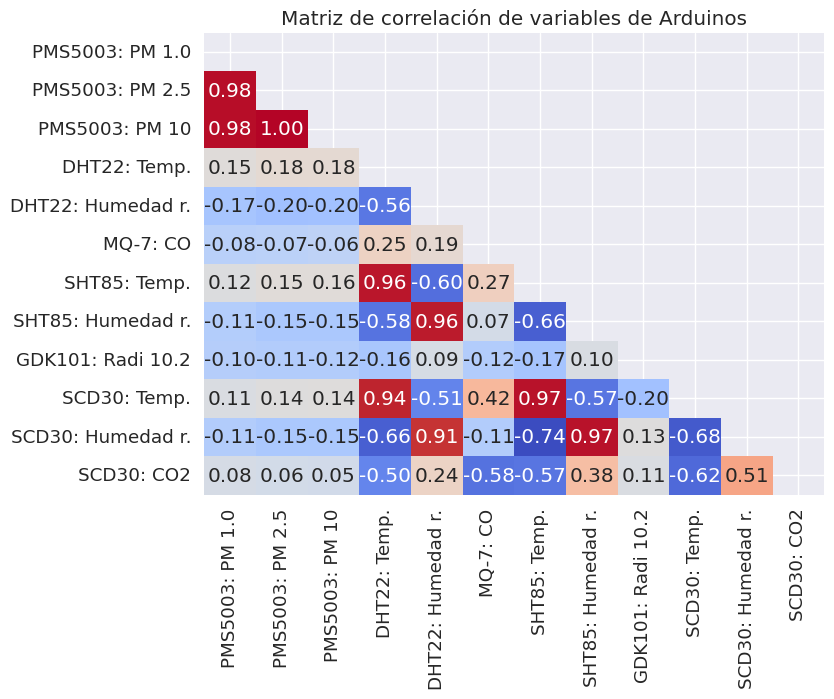

In [12]:
correlation_matrix = df_arduinos_prioridad.corr(numeric_only=True)

# Crear una máscara para ocultar la mitad superior de la matriz (simetría)
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", cbar=False, mask=mask)

plt.title("Matriz de correlación de variables de Arduinos")
plt.show()


In [13]:
# Eliminar las columnas que no se necesitan
cols_drop = [
    'PMS5003: PM 1.0',
    'PMS5003: PM 10',
    'DHT22: Temp.',
    'DHT22: Humedad r.',
    'SCD30: Temp.',
    'SCD30: Humedad r.'
]

df_arduinos_clean = df_arduinos_prioridad.drop(columns=cols_drop, axis=1)


In [14]:
df_arduinos_clean.head()

,PMS5003: PM 2.5,MQ-7: CO,SHT85: Temp.,SHT85: Humedad r.,GDK101: Radi 10.2,SCD30: CO2,arduino
datetime,,,,,,,
2025-07-31 08:50:00,22.20,6.940,29.390,42.330,6.670,271.380,A2
2025-08-08 09:30:00,23.10,5.100,29.110,43.890,6.670,446.790,A1
2025-08-17 11:20:00,32.20,2.580,33.360,40.610,16.440,388.320,A2
2025-08-17 11:30:00,35.16,0.888,35.864,40.452,15.956,376.300,A2
2025-08-17 11:40:00,36.06,0.798,37.864,37.518,11.530,368.048,A2


# **Carga y limpieza de los datos del sensor de radón Airthings**

**Función para cargar los datos del fichero airthings**

In [15]:
def cargar_airthings(filepath):
    df = pd.read_csv(
        filepath,
        sep=';',
        header=None,
        dtype=str,
        encoding='utf-8',
        on_bad_lines='skip'
    )

    # La primera fila es la cabecera
    column_names = df.iloc[0].tolist()

    # Convertir la columna de la fecha
    df['datetime'] = pd.to_datetime(df[0], format='%Y-%m-%d %H:%M:%S', errors='coerce')

    # Quedarse solo con las filas que tienen fecha válida
    df_clean = df[df['datetime'].notna()].copy()

    # Asignar nombres de columnas
    df_clean.columns = column_names + ['datetime']

    # Convertir tipos numéricos
    numeric_cols = list(df_clean.columns.values)
    numeric_cols.remove('datetime')
    for col in numeric_cols:
        df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')

    df_clean = df_clean.drop(columns=['fechayhora'])

    # Renombrar columnas para claridad en análisis posterior
    rename_dict = {col: f"{col}_airthings" for col in numeric_cols}
    df_clean = df_clean.rename(columns=rename_dict)

    # Quedarse con el primer registro de cada timestamp
    df_clean = df_clean.drop_duplicates(subset='datetime', keep='first')

    return df_clean


In [16]:
# Cargar datos de radón
df_radon = cargar_airthings(os.path.join(ruta_base, 'airthings.csv'))
df_radon.shape

(27777, 7)

In [17]:
# Resample del dataframe de radón
df_radon_r = df_radon.set_index('datetime').resample('10min').mean()

# Ordenar los datos por fecha
df_radon_r = df_radon_r.sort_index()
df_radon_r.shape

(14104, 6)

# **Carga y limpieza de los datos de la estación meteorológica**

In [18]:
def cargar_wunder(filepath):
    df = pd.read_csv(
        filepath,
        sep=';',
        header=None,
        dtype=str,
        encoding='utf-8',
        on_bad_lines='skip'
    )

    # La primera fila es la cabecera
    column_names = df.iloc[0].tolist()

    # Convertir a datetime (formato ISO, no europeo)
    df['datetime'] = pd.to_datetime(df[0], format='%Y-%m-%d %H:%M:%S', errors='coerce')

    # Quedarse solo con las filas que tienen fecha válida
    df_clean = df[df['datetime'].notna()].copy()

    # Eliminar columna 0 y asignar nombres
    df_clean = df_clean.drop(columns=[0])
    df_clean.columns = column_names[1:] + ['datetime']

    # Obtener nombre de las columnas numéricas
    numeric_cols = list(df_clean.columns.values)
    numeric_cols.remove('datetime')

    # Convertir tipos numéricos
    for col in numeric_cols:
        if col in df_clean.columns:
            df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')

    df_clean = df_clean.drop(columns=['Direccion'])

    # Renombrar con sufijo _meteo
    rename_dict = {col: f"{col}_meteo" for col in df_clean.columns if col != 'datetime'}
    df_clean = df_clean.rename(columns=rename_dict)

    # Quedarse con el primer registro de cada timestamp
    df_clean = df_clean.drop_duplicates(subset='datetime', keep='first')

    return df_clean

In [19]:
df_meteo = cargar_wunder(os.path.join(ruta_base, 'wunder.csv'))
df_meteo.shape

(26791, 12)

In [20]:
# Resample del dataframe de la estación meteorológica
df_meteo_r = df_meteo.set_index('datetime').resample('10min').mean()

# Ordenar los datos por fecha
df_meteo_r = df_meteo_r.sort_index()
df_meteo_r.shape

(14081, 11)

In [21]:
# Eliminar las variables de la estación meteorológica que no se van a utilizar
df_meteo_final = df_meteo_r.copy()
df_meteo_final = df_meteo_final.drop(columns=['Sensación Termica_meteo', 'Indice de Calor_meteo', 'Elevacion_meteo', 'Rafaga de Viento_meteo', 'Tasa de Precipitacion_meteo'], axis=1)
df_meteo_final.head()

,Temperatura_meteo,Punto de Rocio_meteo,Velocidad del Viento_meteo,Presion_meteo,Total de Precipitacion_meteo,Humedad_meteo
datetime,,,,,,
2025-08-13 14:10:00,39.633333,10.933333,0.266667,1013.900000,0.0,18.000000
2025-08-13 14:20:00,40.300000,9.700000,4.000000,1013.880000,0.0,16.000000
2025-08-13 14:30:00,39.550000,10.450000,0.550000,1013.800000,0.0,17.500000
2025-08-13 14:40:00,39.866667,10.833333,2.900000,1013.683333,0.0,17.666667
2025-08-13 14:50:00,39.900000,10.300000,3.050000,1013.770000,0.0,17.000000


**Unir los datasets para la entrada al modelo**

In [22]:
# 1. Unir datasets
df_merge = pd.merge(
    left=df_arduinos_clean,
    right=df_radon_r['radon_airthings'],
    left_index=True,
    right_index=True,
    how='inner'
)
print(f"Registros tras unir con Airthings: {len(df_merge)}")

df_final_nuevo = pd.merge(
    left=df_merge,
    right=df_meteo_final,
    left_index=True,
    right_index=True,
    how='left'
)
print(f"Registros tras unir con estación meteorológica: {len(df_final_nuevo)}")

# 2. Interpolar SOLO las features (no el radón)
columnas_features = [col for col in df_final_nuevo.columns if col != 'radon_airthings']
df_final_nuevo[columnas_features] = df_final_nuevo[columnas_features].interpolate(method='time', limit=3)

# 3. Eliminar filas donde el radón sea NaN (no inventar valores del target)
df_final_nuevo = df_final_nuevo.dropna(subset=['radon_airthings'])

# 4. Eliminar filas donde las features aún tengan NaN
df_final_nuevo = df_final_nuevo.dropna()

print(f"Registros finales: {len(df_final_nuevo)}")
print(f"Rango: {df_final_nuevo.index.min()} a {df_final_nuevo.index.max()}")


Registros tras unir con Airthings: 7747
Registros tras unir con estación meteorológica: 7747
Registros finales: 5154
Rango: 2025-08-17 11:30:00 a 2025-11-19 08:50:00


**Matriz de correlación de todas las variables**

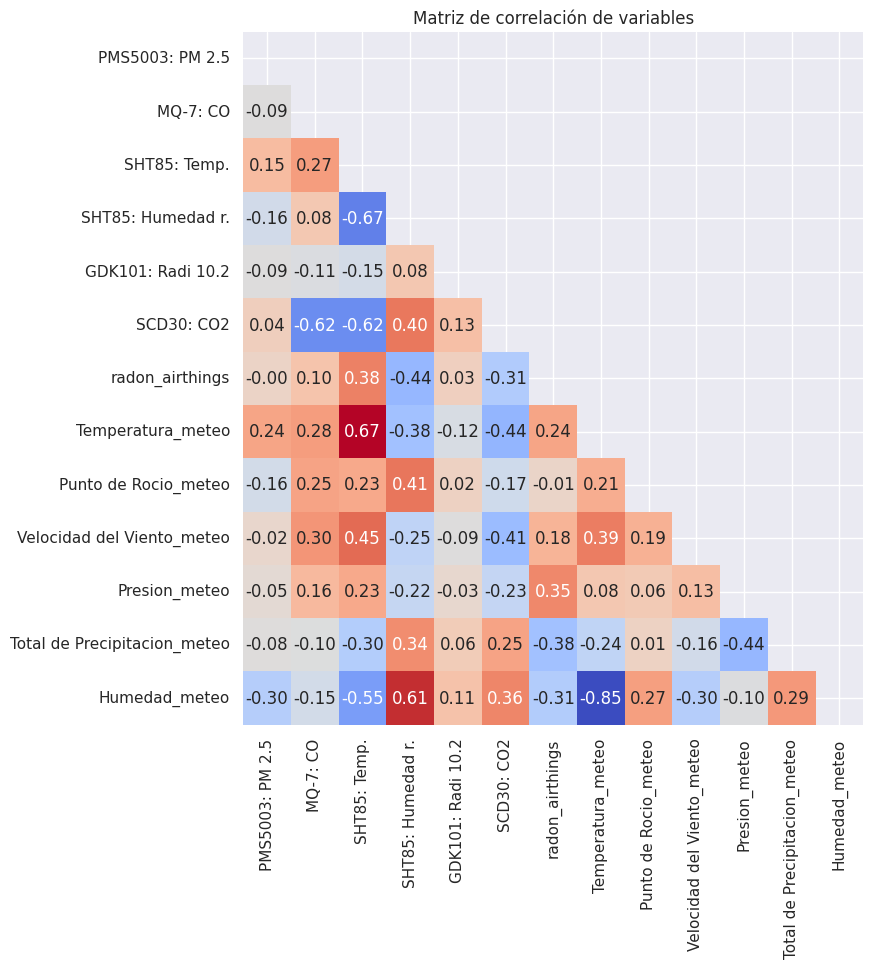

In [23]:
correlation_matrix = df_final_nuevo.corr(numeric_only=True)

# Crear una máscara para ocultar la mitad superior de la matriz (simetría)
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
plt.figure(figsize=(8, 9))
sns.set(font_scale=1)

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", cbar=False, mask=mask)

plt.title("Matriz de correlación de variables")
plt.show()

In [24]:
###########################################################
# Comprobar correlación PM vs radón
print(df_final_nuevo[['PMS5003: PM 2.5', 'radon_airthings']].corr())

# Por si hay relación retardada (el PM captura descendientes horas después)
for lag in [0, 6, 12, 36]:
    corr = df_final_nuevo['PMS5003: PM 2.5'].corr(
        df_final_nuevo['radon_airthings'].shift(lag)  # PM actual vs radón PASADO
    )
    print(f"PM actual vs radón hace {lag*10}min: {corr:.3f}")

                 PMS5003: PM 2.5  radon_airthings
PMS5003: PM 2.5          1.00000         -0.00048
radon_airthings         -0.00048          1.00000
PM actual vs radón hace 0min: -0.000
PM actual vs radón hace 60min: 0.008
PM actual vs radón hace 120min: 0.009
PM actual vs radón hace 360min: 0.021


Eliminar la columna de PM del dataset, ya que no tiene ninguna correlación

In [25]:
df_final_nuevo = df_final_nuevo.drop(columns=['PMS5003: PM 2.5'], axis=1)

# **Feature Engineering (Enriquecer el dataset con variables con retardo)**

**Analizar el comportamiento del radón con el tiempo**

In [26]:
# Correlación variables externas con retardos (el radón responde a cambios pasados)
for lag in [1, 3, 6, 12, 18, 24, 36, 48, 60]:  # en intervalos de 10 min
    corr_presion = df_final_nuevo['radon_airthings'].corr(df_final_nuevo['Presion_meteo'].shift(lag))
    print(f"Correlación radón vs presión exterior (lag {lag*10} min): {corr_presion:.3f}")
for lag in [1, 3, 6, 12, 18, 24, 36, 48, 60]:  # en intervalos de 10 min
    corr_temp = df_final_nuevo['radon_airthings'].corr(df_final_nuevo['Temperatura_meteo'].shift(lag))
    print(f"Correlación radón vs temperatura exterior (lag {lag*10} min): {corr_temp:.3f}")
for lag in [1, 3, 6, 12, 18, 24, 36, 48, 60]:  # en intervalos de 10 min
    corr_hr = df_final_nuevo['radon_airthings'].corr(df_final_nuevo['Humedad_meteo'].shift(lag))
    print(f"Correlación radón vs humedad relativa exterior (lag {lag*10} min): {corr_hr:.3f}")

Correlación radón vs presión exterior (lag 10 min): 0.354
Correlación radón vs presión exterior (lag 30 min): 0.358
Correlación radón vs presión exterior (lag 60 min): 0.362
Correlación radón vs presión exterior (lag 120 min): 0.368
Correlación radón vs presión exterior (lag 180 min): 0.374
Correlación radón vs presión exterior (lag 240 min): 0.378
Correlación radón vs presión exterior (lag 360 min): 0.380
Correlación radón vs presión exterior (lag 480 min): 0.375
Correlación radón vs presión exterior (lag 600 min): 0.365
Correlación radón vs temperatura exterior (lag 10 min): 0.244
Correlación radón vs temperatura exterior (lag 30 min): 0.242
Correlación radón vs temperatura exterior (lag 60 min): 0.239
Correlación radón vs temperatura exterior (lag 120 min): 0.231
Correlación radón vs temperatura exterior (lag 180 min): 0.224
Correlación radón vs temperatura exterior (lag 240 min): 0.221
Correlación radón vs temperatura exterior (lag 360 min): 0.216
Correlación radón vs temperatura e

La presión exterior tiene máxima correlación a las 6 horas

In [27]:
# Correlación variables internas con retardo
for lag in [1, 3, 6, 12, 18, 24, 36, 48, 60]:  # en intervalos de 10 min
    corr_gamma = df_final_nuevo['radon_airthings'].corr(df_final_nuevo['GDK101: Radi 10.2'].shift(lag))
    print(f"Correlación radón vs radiación gamma (lag {lag*10} min): {corr_gamma:.3f}")

for lag in [1, 3, 6, 12, 18, 24, 36, 48, 60]:  # en intervalos de 10 min
    corr_hrint = df_final_nuevo['radon_airthings'].corr(df_final_nuevo['SHT85: Humedad r.'].shift(lag))
    print(f"Correlación radón vs humedad relativa interior (lag {lag*10} min): {corr_hrint:.3f}")

for lag in [1, 3, 6, 12, 18, 24, 36, 48, 60]:  # en intervalos de 10 min
    corr_tempint = df_final_nuevo['radon_airthings'].corr(df_final_nuevo['SHT85: Temp.'].shift(lag))
    print(f"Correlación radón vs temperatura interior (lag {lag*10} min): {corr_tempint:.3f}")

for lag in [1, 3, 6, 12, 18, 24, 36, 48, 60]:  # en intervalos de 10 min
    corr_co2 = df_final_nuevo['radon_airthings'].corr(df_final_nuevo['SCD30: CO2'].shift(lag))
    print(f"Correlación radón vs CO2 interior (lag {lag*10} min): {corr_co2:.3f}")

Correlación radón vs radiación gamma (lag 10 min): 0.028
Correlación radón vs radiación gamma (lag 30 min): 0.025
Correlación radón vs radiación gamma (lag 60 min): 0.024
Correlación radón vs radiación gamma (lag 120 min): 0.024
Correlación radón vs radiación gamma (lag 180 min): 0.031
Correlación radón vs radiación gamma (lag 240 min): 0.029
Correlación radón vs radiación gamma (lag 360 min): 0.013
Correlación radón vs radiación gamma (lag 480 min): -0.006
Correlación radón vs radiación gamma (lag 600 min): -0.019
Correlación radón vs humedad relativa interior (lag 10 min): -0.437
Correlación radón vs humedad relativa interior (lag 30 min): -0.437
Correlación radón vs humedad relativa interior (lag 60 min): -0.438
Correlación radón vs humedad relativa interior (lag 120 min): -0.440
Correlación radón vs humedad relativa interior (lag 180 min): -0.443
Correlación radón vs humedad relativa interior (lag 240 min): -0.445
Correlación radón vs humedad relativa interior (lag 360 min): -0.441

La correlación con humedad relativa interna va subiendo hasta alcanzar el máximo a las 4 horas.
La temperatura interior tiene máxima correlación a las 10 horas.

In [28]:
# Ver cómo afecta la diferencia de tempertauras interior vs exterior
df_temp = df_final_nuevo.copy()
df_temp['diff_temp'] = df_temp['SHT85: Temp.'] - df_temp['Temperatura_meteo']

# Ver la correlación numérica directa
corr_delta = df_temp['radon_airthings'].corr(df_temp['diff_temp'])
print(f"Correlación Radón vs Delta_Temp: {corr_delta:.4f}")

Correlación Radón vs Delta_Temp: -0.0910


In [29]:
# Ver cómo afecta la diferencia de humedad interior vs exterior
df_hr = df_final_nuevo.copy()
df_hr['diff_hr'] = df_hr['SHT85: Humedad r.'] - df_hr['Humedad_meteo']

# Ver la correlación numérica directa
corr_delta = df_hr['radon_airthings'].corr(df_hr['diff_hr'])
print(f"Correlación Radón vs Delta_Hum: {corr_delta:.4f}")

Correlación Radón vs Delta_Hum: 0.2190


In [30]:
# Ver si la presión también cambió
lags = [1, 3, 6, 12, 18, 24, 36, 48, 60]  # intervalos de 10min
print("Correlación radón vs presión exterior:")
for lag in lags:
    corr = df_final_nuevo['Presion_meteo'].shift(lag).corr(df_final_nuevo['radon_airthings'])
    print(f"  Lag {lag*10} min: {corr:.3f}")

Correlación radón vs presión exterior:
  Lag 10 min: 0.354
  Lag 30 min: 0.358
  Lag 60 min: 0.362
  Lag 120 min: 0.368
  Lag 180 min: 0.374
  Lag 240 min: 0.378
  Lag 360 min: 0.380
  Lag 480 min: 0.375
  Lag 600 min: 0.365


In [31]:
# Limpiar nombres de columnas primero
import re
def limpiar_nombre(nombre):
    nombre = nombre.replace(':', '_').replace(' ', '_').replace('.', '').replace('__', '_')
    nombre = re.sub(r'[^\w]', '', nombre)
    return nombre

df_modelo_a2 = df_final_nuevo.copy()
df_modelo_a2.columns = [limpiar_nombre(col) for col in df_modelo_a2.columns]
df_modelo_a2.columns

Index(['MQ7_CO', 'SHT85_Temp', 'SHT85_Humedad_r', 'GDK101_Radi_102',
       'SCD30_CO2', 'arduino', 'radon_airthings', 'Temperatura_meteo',
       'Punto_de_Rocio_meteo', 'Velocidad_del_Viento_meteo', 'Presion_meteo',
       'Total_de_Precipitacion_meteo', 'Humedad_meteo'],
      dtype='object')

In [32]:
# Features temporales
df_modelo_a2['Hora'] = df_modelo_a2.index.hour
df_modelo_a2['Mes'] = df_modelo_a2.index.month
df_modelo_a2['Hora_Sin'] = np.sin(2 * np.pi * df_modelo_a2['Hora'] / 24.0)
df_modelo_a2['Hora_Cos'] = np.cos(2 * np.pi * df_modelo_a2['Hora'] / 24.0)
df_modelo_a2['Mes_Sin'] = np.sin(2 * np.pi * df_modelo_a2['Mes'] / 12.0)
df_modelo_a2['Mes_Cos'] = np.cos(2 * np.pi * df_modelo_a2['Mes'] / 12.0)

# Features derivadas CON LAGS ÓPTIMOS PARA PRIORIDAD A2
df_modelo_a2['Presion_Lag_6h'] = df_modelo_a2['Presion_meteo'].shift(36)           # 6h = 36 intervalos
df_modelo_a2['Humedad_Lag_4h'] = df_modelo_a2['SHT85_Humedad_r'].shift(24)         # 4h = 24 intervalos
df_modelo_a2['Temp_Int_Media_10h'] = df_modelo_a2['SHT85_Temp'].rolling(60).mean() # 10h = 60 intervalos

# Tendencias
df_modelo_a2['Presion_Tendencia_6h'] = df_modelo_a2['Presion_meteo'].diff(36)
df_modelo_a2['Humedad_Tendencia_4h'] = df_modelo_a2['SHT85_Humedad_r'].diff(24)
df_modelo_a2['Temp_Int_Tendencia_6h'] = df_modelo_a2['SHT85_Temp'].diff(36)

# Media de presión (ajustar a 6h también)
df_modelo_a2['Presion_Media_6h'] = df_modelo_a2['Presion_meteo'].rolling(36).mean()

# Crear diferencia de humedad
df_modelo_a2['Diff_Hum_In_Out'] = df_modelo_a2['SHT85_Humedad_r'] - df_modelo_a2['Humedad_meteo']

# Eliminar NaN generados por los lags
df_modelo_a2 = df_modelo_a2.dropna()

print(f"Registros finales: {len(df_modelo_a2)}")

Registros finales: 5095


In [33]:
df_modelo_a2.columns


Index(['MQ7_CO', 'SHT85_Temp', 'SHT85_Humedad_r', 'GDK101_Radi_102',
       'SCD30_CO2', 'arduino', 'radon_airthings', 'Temperatura_meteo',
       'Punto_de_Rocio_meteo', 'Velocidad_del_Viento_meteo', 'Presion_meteo',
       'Total_de_Precipitacion_meteo', 'Humedad_meteo', 'Hora', 'Mes',
       'Hora_Sin', 'Hora_Cos', 'Mes_Sin', 'Mes_Cos', 'Presion_Lag_6h',
       'Humedad_Lag_4h', 'Temp_Int_Media_10h', 'Presion_Tendencia_6h',
       'Humedad_Tendencia_4h', 'Temp_Int_Tendencia_6h', 'Presion_Media_6h',
       'Diff_Hum_In_Out'],
      dtype='object')

# **Modelos**

In [34]:
features_a2 = [
    'GDK101_Radi_102',
    'MQ7_CO',
    'SHT85_Temp',
    'SHT85_Humedad_r',
    'SCD30_CO2',

    # Meteo
    'Temperatura_meteo',
    'Velocidad_del_Viento_meteo',
    'Presion_meteo',
    'Total_de_Precipitacion_meteo',
    'Humedad_meteo',
    'Punto_de_Rocio_meteo',

    # Temporales
    'Hora_Sin', 'Hora_Cos', 'Mes_Sin', 'Mes_Cos',

    # Derivadas (lags óptimos para A2)
    'Presion_Lag_6h',
    'Humedad_Lag_4h',
    'Temp_Int_Media_10h',
    'Presion_Tendencia_6h',
    'Humedad_Tendencia_4h',
    'Temp_Int_Tendencia_6h',
    'Presion_Media_6h',

    # Diferencia interior/exterior
    'Diff_Hum_In_Out'
]

print(f"Total features: {len(features_a2)}")

Total features: 23


In [35]:
# Modelos con sus grids de hiperparámetros
modelos = {
    'Ridge': {
        'modelo': Pipeline([
            ('scaler', StandardScaler()),
            ('reg', Ridge())
        ]),
        'params': {
            'reg__alpha': [0.1, 1, 10, 100]
        }
    },
    'ElasticNet': {
        'modelo': Pipeline([
            ('scaler', StandardScaler()),
            ('reg', ElasticNet(max_iter=10000))
        ]),
        'params': {
            'reg__alpha': [0.1, 1, 10],
            'reg__l1_ratio': [0.2, 0.5, 0.8]
        }
    },
    'RandomForest': {
        'modelo': RandomForestRegressor(random_state=42),
        'params': {
            'n_estimators': [100, 200],
            'max_depth': [10, 20, None],
            'min_samples_split': [2, 5]
        }
    },
    'XGBoost': {
        'modelo': XGBRegressor(random_state=42),
        'params': {
            'n_estimators': [100, 200],
            'max_depth': [3, 6, 10],
            'learning_rate': [0.05, 0.1],
            'subsample': [0.8, 1.0]
        }
    },
    'LightGBM': {
        'modelo': LGBMRegressor(random_state=42, verbose=-1),
        'params': {
            'n_estimators': [100, 200],
            'max_depth': [3, 6, 10],
            'learning_rate': [0.05, 0.1],
            'subsample': [0.8, 1.0]
        }
    }
}

horizontes = {
    '30min': 3,
    '1h': 6,
    '2h': 12,
    '3h': 18,
    '6h': 36
}

resultados = []

for nombre_horizonte, horizonte in horizontes.items():
    print(f"\n{'='*60}")
    print(f"HORIZONTE: {nombre_horizonte}")
    print('='*60)

    # Preparar datos
    df_temp = df_modelo_a2.copy()
    df_temp['radon_futuro'] = df_temp['radon_airthings'].shift(-horizonte)
    df_temp = df_temp.dropna()

    X = df_temp[features_a2]
    y = df_temp['radon_futuro']

    # Split 80/20
    split_idx = int(len(X) * 0.8)
    X_train, X_test = X[:split_idx], X[split_idx:]
    y_train, y_test = y[:split_idx], y[split_idx:]

    for nombre_modelo, config in modelos.items():
        print(f"\n  {nombre_modelo}...")

        grid = GridSearchCV(
            config['modelo'],
            config['params'],
            cv=3,
            scoring='r2',
            n_jobs=1
        )
        grid.fit(X_train, y_train)

        # Predicciones en train y test
        y_pred_train = grid.best_estimator_.predict(X_train)
        y_pred_test = grid.best_estimator_.predict(X_test)

        # Métricas en train
        r2_train = r2_score(y_train, y_pred_train)
        mae_train = mean_absolute_error(y_train, y_pred_train)

        # Métricas en test
        r2_test = r2_score(y_test, y_pred_test)
        mae_test = mean_absolute_error(y_test, y_pred_test)

        resultados.append({
            'horizonte': nombre_horizonte,
            'modelo': nombre_modelo,
            'R2_train': r2_train,
            'R2_test': r2_test,
            'Overfit': r2_train - r2_test,  # Diferencia indica overfitting
            'MAE_train': mae_train,
            'MAE_test': mae_test,
            'mejores_params': grid.best_params_,
            'mejor_estimador': grid.best_estimator_
        })

        print(f"  {nombre_modelo:15} → Train R²: {r2_train:.3f}, Test R²: {r2_test:.3f}, Overfit: {r2_train - r2_test:.3f}")

# Resumen
df_resultados = pd.DataFrame(resultados)

print("\n" + "="*60)
print("MEJOR MODELO POR HORIZONTE")
print("="*60)
mejores = df_resultados.loc[df_resultados.groupby('horizonte')['R2_test'].idxmax()]
print(mejores[['horizonte', 'modelo', 'R2_train', 'R2_test', 'Overfit', 'MAE_test']].to_string(index=False))


HORIZONTE: 30min

  Ridge...
  Ridge           → Train R²: 0.292, Test R²: 0.078, Overfit: 0.214

  ElasticNet...
  ElasticNet      → Train R²: 0.113, Test R²: -0.156, Overfit: 0.269

  RandomForest...
  RandomForest    → Train R²: 0.997, Test R²: 0.493, Overfit: 0.503

  XGBoost...
  XGBoost         → Train R²: 0.747, Test R²: 0.298, Overfit: 0.449

  LightGBM...
  LightGBM        → Train R²: 0.737, Test R²: 0.380, Overfit: 0.358

HORIZONTE: 1h

  Ridge...
  Ridge           → Train R²: 0.294, Test R²: 0.070, Overfit: 0.224

  ElasticNet...
  ElasticNet      → Train R²: 0.114, Test R²: -0.158, Overfit: 0.271

  RandomForest...
  RandomForest    → Train R²: 0.996, Test R²: 0.499, Overfit: 0.497

  XGBoost...
  XGBoost         → Train R²: 0.747, Test R²: 0.335, Overfit: 0.412

  LightGBM...
  LightGBM        → Train R²: 0.837, Test R²: 0.296, Overfit: 0.540

HORIZONTE: 2h

  Ridge...
  Ridge           → Train R²: 0.300, Test R²: 0.061, Overfit: 0.239

  ElasticNet...
  ElasticNet      →

Los modelos tienen un severo sobreajuste

**Ver la importancia de las variables en el modelo ganador (RandomForest con horizonte temporal de 1 hora)**

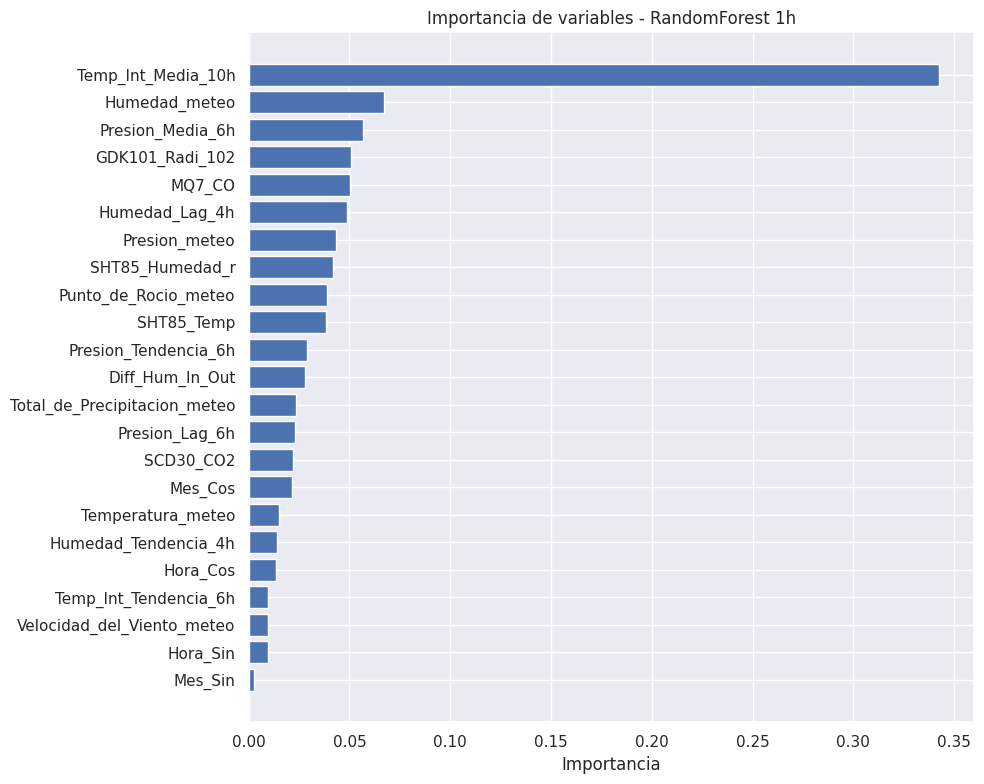

                     feature  importancia
          Temp_Int_Media_10h     0.342751
               Humedad_meteo     0.067204
            Presion_Media_6h     0.056759
             GDK101_Radi_102     0.050635
                      MQ7_CO     0.050167
              Humedad_Lag_4h     0.048556
               Presion_meteo     0.043478
             SHT85_Humedad_r     0.042027
        Punto_de_Rocio_meteo     0.038971
                  SHT85_Temp     0.038157
        Presion_Tendencia_6h     0.028976
             Diff_Hum_In_Out     0.027900
Total_de_Precipitacion_meteo     0.023466
              Presion_Lag_6h     0.022984
                   SCD30_CO2     0.022205
                     Mes_Cos     0.021295
           Temperatura_meteo     0.015159
        Humedad_Tendencia_4h     0.014146
                    Hora_Cos     0.013720
       Temp_Int_Tendencia_6h     0.009740
  Velocidad_del_Viento_meteo     0.009622
                    Hora_Sin     0.009581
                     Mes_Sin     0

In [36]:
# Obtener el mejor modelo RandomForest de 1h
mejor_rf = df_resultados[
    (df_resultados['horizonte'] == '1h') &
    (df_resultados['modelo'] == 'RandomForest')
]['mejor_estimador'].values[0]

# Extraer importancias
importancias = pd.DataFrame({
    'feature': features_a2,
    'importancia': mejor_rf.feature_importances_
}).sort_values('importancia', ascending=True)

# Visualizar
plt.figure(figsize=(10, 8))
plt.barh(importancias['feature'], importancias['importancia'])
plt.xlabel('Importancia')
plt.title('Importancia de variables - RandomForest 1h')
plt.tight_layout()
plt.show()

# Ver valores numéricos
print(importancias.sort_values('importancia', ascending=False).to_string(index=False))

El modelo da muy poca importancia a 4 de las variables. De ellas, se van a eliminar las variables temporales del Mes, ya que no se tiene un ciclo completo de un año y será difícil que aprendan de ella, la Velocidad del Viento, que tenía muy poca correlación con el radón y la variable de tendencia de la Temperatura interna a las 6 horas.

**Solución sin variables menos importantes**

In [37]:
features_a2_reducidas = [
    'GDK101_Radi_102',
    'MQ7_CO',
    'SHT85_Temp',
    'SHT85_Humedad_r',
    'SCD30_CO2',

    # Meteo
    'Temperatura_meteo',
    'Presion_meteo',
    'Total_de_Precipitacion_meteo',
    'Humedad_meteo',
    'Punto_de_Rocio_meteo',

    # Temporales
    'Hora_Sin', 'Hora_Cos',

    # Derivadas (lags óptimos para A2)
    'Presion_Lag_6h',
    'Humedad_Lag_4h',
    'Temp_Int_Media_10h',
    'Presion_Tendencia_6h',
    'Humedad_Tendencia_4h',
    'Presion_Media_6h',

    # Diferencia interior/exterior
    'Diff_Hum_In_Out'
]

print(f"Total features: {len(features_a2_reducidas)}")

Total features: 19


**Entrenar con menos regularización**

In [38]:
# Modelos con sus grids de hiperparámetros
modelos = {
    'RandomForest': {
        'modelo': RandomForestRegressor(random_state=42),
        'params': {
            'n_estimators': [100, 150],
            'max_depth': [3, 4, 5, 6],
            'min_samples_split': [2, 5],
        }
    },
    'XGBoost': {
        'modelo': XGBRegressor(random_state=42),
        'params': {
            'n_estimators': [100, 150],
            'max_depth': [3, 4, 5, 6, 10],
            'learning_rate': [0.03, 0.05],
            'subsample': [0.05, 0.07, 0.8],
        }
    },
    'LightGBM': {
        'modelo': LGBMRegressor(random_state=42, verbose=-1),
        'params': {
            'n_estimators': [100, 150],
            'max_depth': [3, 4, 5, 6, 10],
            'learning_rate': [0.03, 0.05],
            'subsample': [0.05, 0.07, 0.8],
            'min_child_samples': [15, 20],
        }
    }
}

horizontes = {
    '30min': 3,
    '1h': 6,
    '2h': 12,
    '3h': 18,
    '6h': 36
}

resultados = []

for nombre_horizonte, horizonte in horizontes.items():
    print(f"\n{'='*60}")
    print(f"HORIZONTE: {nombre_horizonte}")
    print('='*60)

    # Preparar datos
    df_temp = df_modelo_a2.copy()
    df_temp['radon_futuro'] = df_temp['radon_airthings'].shift(-horizonte)
    df_temp = df_temp.dropna()

    X = df_temp[features_a2_reducidas]
    y = df_temp['radon_futuro']

    # Split 80/20
    split_idx = int(len(X) * 0.8)
    X_train, X_test = X[:split_idx], X[split_idx:]
    y_train, y_test = y[:split_idx], y[split_idx:]

    for nombre_modelo, config in modelos.items():
        print(f"\n  {nombre_modelo}...")

        grid = GridSearchCV(
            config['modelo'],
            config['params'],
            cv=3,
            scoring='r2',
            n_jobs=1
        )
        grid.fit(X_train, y_train)

        # Predicciones en train y test
        y_pred_train = grid.best_estimator_.predict(X_train)
        y_pred_test = grid.best_estimator_.predict(X_test)

        # Métricas en train
        r2_train = r2_score(y_train, y_pred_train)
        mae_train = mean_absolute_error(y_train, y_pred_train)

        # Métricas en test
        r2_test = r2_score(y_test, y_pred_test)
        mae_test = mean_absolute_error(y_test, y_pred_test)

        resultados.append({
            'horizonte': nombre_horizonte,
            'modelo': nombre_modelo,
            'R2_train': r2_train,
            'R2_test': r2_test,
            'Overfit': r2_train - r2_test,  # Diferencia indica overfitting
            'MAE_train': mae_train,
            'MAE_test': mae_test,
            'mejores_params': grid.best_params_,
            'mejor_estimador': grid.best_estimator_
        })

        print(f"  {nombre_modelo:15} → Train R²: {r2_train:.3f}, Test R²: {r2_test:.3f}, Overfit: {r2_train - r2_test:.3f}")

# Resumen
df_resultados = pd.DataFrame(resultados)

print("\n" + "="*60)
print("MEJOR MODELO POR HORIZONTE")
print("="*60)
mejores = df_resultados.loc[df_resultados.groupby('horizonte')['R2_test'].idxmax()]
print(mejores[['horizonte', 'modelo', 'R2_train', 'R2_test', 'Overfit', 'MAE_test']].to_string(index=False))


HORIZONTE: 30min

  RandomForest...
  RandomForest    → Train R²: 0.616, Test R²: 0.042, Overfit: 0.574

  XGBoost...
  XGBoost         → Train R²: 0.837, Test R²: 0.003, Overfit: 0.834

  LightGBM...
  LightGBM        → Train R²: 0.663, Test R²: 0.314, Overfit: 0.349

HORIZONTE: 1h

  RandomForest...
  RandomForest    → Train R²: 0.615, Test R²: 0.219, Overfit: 0.396

  XGBoost...
  XGBoost         → Train R²: 0.889, Test R²: 0.140, Overfit: 0.748

  LightGBM...
  LightGBM        → Train R²: 0.670, Test R²: 0.251, Overfit: 0.419

HORIZONTE: 2h

  RandomForest...
  RandomForest    → Train R²: 0.603, Test R²: 0.307, Overfit: 0.296

  XGBoost...
  XGBoost         → Train R²: 0.842, Test R²: 0.110, Overfit: 0.731

  LightGBM...
  LightGBM        → Train R²: 0.781, Test R²: 0.154, Overfit: 0.627

HORIZONTE: 3h

  RandomForest...
  RandomForest    → Train R²: 0.609, Test R²: 0.232, Overfit: 0.377

  XGBoost...
  XGBoost         → Train R²: 0.874, Test R²: 0.164, Overfit: 0.710

  LightGBM.

Con menos regularización, los R2 empeoran

**Regularización Intermedia**

In [39]:
modelos_intermedio = {
    'RandomForest': RandomForestRegressor(
        n_estimators=100,
        max_depth=6,              # Intermedio
        min_samples_leaf=10,      # Intermedio
        min_samples_split=15,
        max_features='sqrt',
        random_state=42
    ),
    'XGBoost': XGBRegressor(
        n_estimators=100,
        max_depth=4,              # Intermedio
        learning_rate=0.03,       # Intermedio
        min_child_weight=10,
        reg_alpha=1,              # Moderada
        reg_lambda=3,             # Moderada
        subsample=0.7,
        colsample_bytree=0.7,
        random_state=42
    ),
    'LightGBM': LGBMRegressor(
        n_estimators=100,
        max_depth=4,              # Intermedio
        learning_rate=0.03,       # Intermedio
        min_child_samples=20,     # Intermedio
        reg_alpha=1,
        reg_lambda=3,
        subsample=0.7,
        colsample_bytree=0.7,
        random_state=42,
        verbose=-1
    )
}

# Probar todos los horizontes
horizontes = {'30min': 3, '1h': 6, '2h': 12, '3h': 18}

resultados = []

for nombre_h, horizonte in horizontes.items():
    df_temp = df_modelo_a2.copy()
    df_temp['radon_futuro'] = df_temp['radon_airthings'].shift(-horizonte)
    df_temp = df_temp.dropna()

    X = df_temp[features_a2_reducidas]
    y = df_temp['radon_futuro']

    split_idx = int(len(X) * 0.8)
    X_train, X_test = X[:split_idx], X[split_idx:]
    y_train, y_test = y[:split_idx], y[split_idx:]

    for nombre_m, modelo in modelos_intermedio.items():
        modelo_clone = modelo.__class__(**modelo.get_params())
        modelo_clone.fit(X_train, y_train)

        r2_train = r2_score(y_train, modelo_clone.predict(X_train))
        r2_test = r2_score(y_test, modelo_clone.predict(X_test))
        mae_test = mean_absolute_error(y_test, modelo_clone.predict(X_test))

        resultados.append({
            'horizonte': nombre_h,
            'modelo': nombre_m,
            'R2_train': r2_train,
            'R2_test': r2_test,
            'Overfit': r2_train - r2_test,
            'MAE_test': mae_test,
        })

df_res = pd.DataFrame(resultados)
print("\nResultados regularización intermedia:")
print("="*70)
print(df_res.sort_values('R2_test', ascending=False).head(10).to_string(index=False))


Resultados regularización intermedia:
horizonte       modelo  R2_train  R2_test  Overfit  MAE_test
    30min RandomForest  0.762063 0.369591 0.392472 32.294378
       1h RandomForest  0.754813 0.357466 0.397348 32.584163
       2h RandomForest  0.760715 0.356365 0.404350 32.257704
       3h RandomForest  0.769237 0.332865 0.436373 33.493471
       3h      XGBoost  0.783567 0.313278 0.470289 34.507130
       3h     LightGBM  0.777970 0.293564 0.484406 34.311629
       2h     LightGBM  0.767662 0.285383 0.482279 34.655784
       1h     LightGBM  0.770192 0.279604 0.490588 34.762383
    30min     LightGBM  0.767761 0.273498 0.494262 35.445283
       2h      XGBoost  0.772170 0.234057 0.538113 35.200318


Los valores de R2 y overfit han mejorado un poco, pero siguen sin ser buenos

**Aumentar el número de árboles (n_estimators=150)**

In [40]:
modelos_intermedio = {
    'RandomForest': RandomForestRegressor(
        n_estimators=150,
        max_depth=6,              # Intermedio
        min_samples_leaf=10,      # Intermedio
        min_samples_split=15,
        max_features='sqrt',
        random_state=42
    ),
    'XGBoost': XGBRegressor(
        n_estimators=150,
        max_depth=4,              # Intermedio
        learning_rate=0.03,       # Intermedio
        min_child_weight=10,
        reg_alpha=1,              # Moderada
        reg_lambda=3,             # Moderada
        subsample=0.7,
        colsample_bytree=0.7,
        random_state=42
    ),
    'LightGBM': LGBMRegressor(
        n_estimators=150,
        max_depth=4,              # Intermedio
        learning_rate=0.03,       # Intermedio
        min_child_samples=20,     # Intermedio
        reg_alpha=1,
        reg_lambda=3,
        subsample=0.7,
        colsample_bytree=0.7,
        random_state=42,
        verbose=-1
    )
}

# Probar todos los horizontes
horizontes = {'30min': 3, '1h': 6, '2h': 12, '3h': 18}

resultados = []

for nombre_h, horizonte in horizontes.items():
    df_temp = df_modelo_a2.copy()
    df_temp['radon_futuro'] = df_temp['radon_airthings'].shift(-horizonte)
    df_temp = df_temp.dropna()

    X = df_temp[features_a2_reducidas]
    y = df_temp['radon_futuro']

    split_idx = int(len(X) * 0.8)
    X_train, X_test = X[:split_idx], X[split_idx:]
    y_train, y_test = y[:split_idx], y[split_idx:]

    for nombre_m, modelo in modelos_intermedio.items():
        modelo_clone = modelo.__class__(**modelo.get_params())
        modelo_clone.fit(X_train, y_train)

        r2_train = r2_score(y_train, modelo_clone.predict(X_train))
        r2_test = r2_score(y_test, modelo_clone.predict(X_test))
        mae_test = mean_absolute_error(y_test, modelo_clone.predict(X_test))

        resultados.append({
            'horizonte': nombre_h,
            'modelo': nombre_m,
            'R2_train': r2_train,
            'R2_test': r2_test,
            'Overfit': r2_train - r2_test,
            'MAE_test': mae_test,
        })

df_res = pd.DataFrame(resultados)
print("\nResultados regularización intermedia:")
print("="*70)
print(df_res.sort_values('R2_test', ascending=False).head(10).to_string(index=False))


Resultados regularización intermedia:
horizonte       modelo  R2_train  R2_test  Overfit  MAE_test
    30min RandomForest  0.762252 0.391517 0.370735 31.689126
       1h RandomForest  0.757394 0.353009 0.404385 32.807106
       2h RandomForest  0.758339 0.346122 0.412218 32.590036
       3h      XGBoost  0.838138 0.344688 0.493450 33.613226
       3h RandomForest  0.771183 0.309357 0.461826 34.170013
       3h     LightGBM  0.833719 0.302938 0.530781 33.831179
    30min     LightGBM  0.826764 0.293294 0.533470 34.925658
       2h      XGBoost  0.824297 0.280354 0.543943 34.121955
       2h     LightGBM  0.816558 0.279698 0.536860 34.473043
       1h      XGBoost  0.825214 0.268788 0.556425 34.556805


Han mejorado los valores de R2 (de 0.369 a 0.3915) y de sobreajuste (de 0.392 a 0.37)

**Ver importancia de variables en el nuevo mejor modelo (RandomForest 30min)**

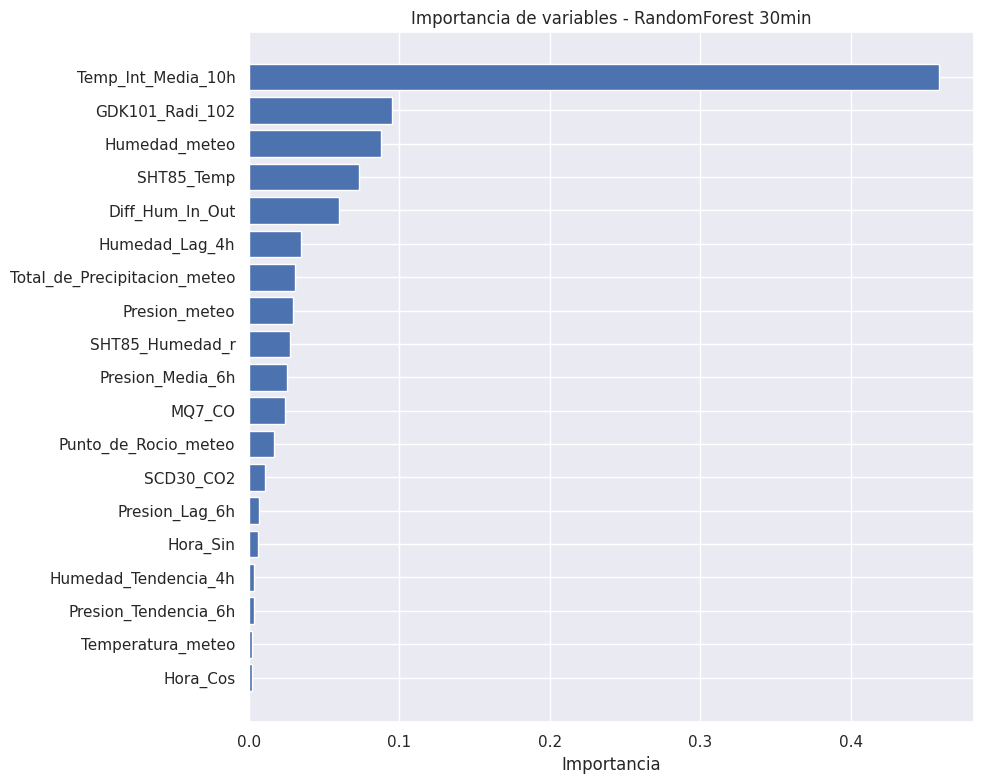

                     feature  importancia
          Temp_Int_Media_10h     0.458941
             GDK101_Radi_102     0.095400
               Humedad_meteo     0.087733
                  SHT85_Temp     0.073417
             Diff_Hum_In_Out     0.059991
              Humedad_Lag_4h     0.034945
Total_de_Precipitacion_meteo     0.030473
               Presion_meteo     0.029554
             SHT85_Humedad_r     0.027534
            Presion_Media_6h     0.025400
                      MQ7_CO     0.023897
        Punto_de_Rocio_meteo     0.017129
                   SCD30_CO2     0.011024
              Presion_Lag_6h     0.006953
                    Hora_Sin     0.006031
        Humedad_Tendencia_4h     0.003678
        Presion_Tendencia_6h     0.003363
           Temperatura_meteo     0.002434
                    Hora_Cos     0.002102


In [41]:
# Obtener el mejor modelo RandomForest de 1h
mejor_rf = df_resultados[
    (df_resultados['horizonte'] == '30min') &
    (df_resultados['modelo'] == 'RandomForest')
]['mejor_estimador'].values[0]

# Extraer importancias
importancias = pd.DataFrame({
    'feature': features_a2_reducidas,
    'importancia': mejor_rf.feature_importances_
}).sort_values('importancia', ascending=True)

# Visualizar
plt.figure(figsize=(10, 8))
plt.barh(importancias['feature'], importancias['importancia'])
plt.xlabel('Importancia')
plt.title('Importancia de variables - RandomForest 30min')
plt.tight_layout()
plt.show()

# Ver valores numéricos
print(importancias.sort_values('importancia', ascending=False).to_string(index=False))

Este modelo no da ninguna importancia a la variable temporal de la Hora. Tampoco a la Temperatura externa, sin embargo, se vio que tenía una correlación con el radón de 0.24.

Se va a probar eliminando las variables temporales, la Tendencia de Presión a las 6h, el Punto de Rocío, ya que parece que tampoco se le da mucha importancia y las variables CO, CO2 y Tendencia de Humedad 4h.

In [42]:
features_mas_reducidas = [
    'GDK101_Radi_102',
    'SHT85_Temp',
    'SHT85_Humedad_r',

    # Meteo
    'Temperatura_meteo',
    'Presion_meteo',
    'Total_de_Precipitacion_meteo',
    'Humedad_meteo',

    # Derivadas (lags óptimos para A2)
    'Presion_Lag_6h',
    'Humedad_Lag_4h',
    'Temp_Int_Media_10h',
    'Presion_Media_6h',

    # Diferencia interior/exterior
    'Diff_Hum_In_Out'
]

print(f"Total features: {len(features_mas_reducidas)}")

Total features: 12


In [43]:
modelos_intermedio = {
    'RandomForest': RandomForestRegressor(
        n_estimators=150,
        max_depth=6,              # Intermedio
        min_samples_leaf=10,      # Intermedio
        min_samples_split=15,
        max_features='sqrt',
        random_state=42
    ),
    'XGBoost': XGBRegressor(
        n_estimators=150,
        max_depth=4,              # Intermedio
        learning_rate=0.03,       # Intermedio
        min_child_weight=10,
        reg_alpha=1,              # Moderada
        reg_lambda=3,             # Moderada
        subsample=0.7,
        colsample_bytree=0.7,
        random_state=42
    ),
    'LightGBM': LGBMRegressor(
        n_estimators=150,
        max_depth=4,              # Intermedio
        learning_rate=0.03,       # Intermedio
        min_child_samples=20,     # Intermedio
        reg_alpha=1,
        reg_lambda=3,
        subsample=0.7,
        colsample_bytree=0.7,
        random_state=42,
        verbose=-1
    )
}

# Probar todos los horizontes
horizontes = {'30min': 3, '1h': 6, '2h': 12, '3h': 18}

resultados = []

for nombre_h, horizonte in horizontes.items():
    df_temp = df_modelo_a2.copy()
    df_temp['radon_futuro'] = df_temp['radon_airthings'].shift(-horizonte)
    df_temp = df_temp.dropna()

    X = df_temp[features_mas_reducidas]
    y = df_temp['radon_futuro']

    split_idx = int(len(X) * 0.8)
    X_train, X_test = X[:split_idx], X[split_idx:]
    y_train, y_test = y[:split_idx], y[split_idx:]

    for nombre_m, modelo in modelos_intermedio.items():
        modelo_clone = modelo.__class__(**modelo.get_params())
        modelo_clone.fit(X_train, y_train)

        r2_train = r2_score(y_train, modelo_clone.predict(X_train))
        r2_test = r2_score(y_test, modelo_clone.predict(X_test))
        mae_test = mean_absolute_error(y_test, modelo_clone.predict(X_test))

        resultados.append({
            'horizonte': nombre_h,
            'modelo': nombre_m,
            'R2_train': r2_train,
            'R2_test': r2_test,
            'Overfit': r2_train - r2_test,
            'MAE_test': mae_test,
        })

df_res = pd.DataFrame(resultados)
print("\nResultados regularización intermedia:")
print("="*70)
print(df_res.sort_values('R2_test', ascending=False).head(10).to_string(index=False))


Resultados regularización intermedia:
horizonte       modelo  R2_train  R2_test  Overfit  MAE_test
       3h     LightGBM  0.795164 0.457541 0.337623 30.424687
       2h      XGBoost  0.801111 0.435424 0.365686 31.186136
       2h     LightGBM  0.794879 0.426992 0.367887 31.540602
    30min     LightGBM  0.807452 0.426078 0.381374 31.584128
       3h      XGBoost  0.815689 0.425606 0.390083 31.754905
       1h      XGBoost  0.809363 0.420322 0.389041 31.577184
       1h     LightGBM  0.799606 0.405743 0.393863 31.706281
    30min      XGBoost  0.805457 0.377409 0.428047 32.758687
       1h RandomForest  0.736321 0.364381 0.371940 32.443383
    30min RandomForest  0.729652 0.359041 0.370611 32.755661


Se obtienen mejores resultados de R2 y overfit para los modelos boosting, sin embargo, RandomForest apenas mejora.

**Importancia de variables en LightGBM con horizonte temporal de 3 horas**

Importancia de features:
                     feature  importancia
          Temp_Int_Media_10h          429
              Humedad_Lag_4h          192
                  SHT85_Temp          189
             SHT85_Humedad_r          183
            Presion_Media_6h          174
               Presion_meteo          172
              Presion_Lag_6h          138
           Temperatura_meteo          113
               Humedad_meteo          103
Total_de_Precipitacion_meteo           91
             Diff_Hum_In_Out           75
             GDK101_Radi_102           60


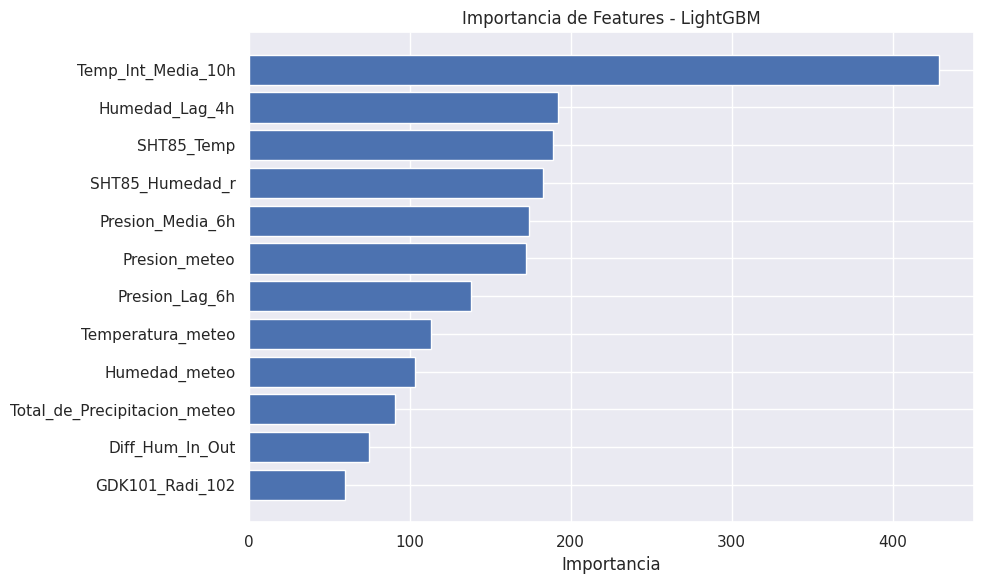

In [44]:
# Entrenar el mejor modelo
horizonte = 18  # 3h

df_temp = df_modelo_a2.copy()
df_temp['radon_futuro'] = df_temp['radon_airthings'].shift(-horizonte)
df_temp = df_temp.dropna()

X = df_temp[features_mas_reducidas]
y = df_temp['radon_futuro']

split_idx = int(len(X) * 0.8)
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

modelo_lgbm = LGBMRegressor(
    n_estimators=150,
    max_depth=4,
    learning_rate=0.03,
    min_child_samples=20,
    reg_alpha=1,
    reg_lambda=3,
    subsample=0.7,
    colsample_bytree=0.7,
    random_state=42,
    verbose=-1
)
modelo_lgbm.fit(X_train, y_train)

# Importancia de features
importancia = pd.DataFrame({
    'feature': features_mas_reducidas,
    'importancia': modelo_lgbm.feature_importances_
}).sort_values('importancia', ascending=False)

print("Importancia de features:")
print(importancia.to_string(index=False))

# Gráfico
plt.figure(figsize=(10, 6))
plt.barh(importancia['feature'], importancia['importancia'])
plt.xlabel('Importancia')
plt.title('Importancia de Features - LightGBM')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

A las variables de Radiación gamma y diferencia de humedad no se les da mucha importancia, por lo que se van a eliminar.
A la variable Total de Precipitación, a pesar de considerarse importante, ya que si el suelo está mojado el radón no puede salir por los poros, se le da poca importancia. De momento, no se va a eliminar a ver qué resultados se obtienen.

In [45]:
features_mas_reducidas = [
    'SHT85_Temp',
    'SHT85_Humedad_r',

    # Meteo
    'Temperatura_meteo',
    'Presion_meteo',
    'Total_de_Precipitacion_meteo',
    'Humedad_meteo',

    # Derivadas (lags óptimos para A2)
    'Presion_Lag_6h',
    'Humedad_Lag_4h',
    'Temp_Int_Media_10h',
    'Presion_Media_6h',
]

print(f"Total features: {len(features_mas_reducidas)}")

Total features: 10


In [46]:
modelos_intermedio = {
    'RandomForest': RandomForestRegressor(
        n_estimators=150,
        max_depth=6,              # Intermedio
        min_samples_leaf=10,      # Intermedio
        min_samples_split=15,
        max_features='sqrt',
        random_state=42
    ),
    'XGBoost': XGBRegressor(
        n_estimators=150,
        max_depth=4,              # Intermedio
        learning_rate=0.03,       # Intermedio
        min_child_weight=10,
        reg_alpha=1,              # Moderada
        reg_lambda=3,             # Moderada
        subsample=0.7,
        colsample_bytree=0.7,
        random_state=42
    ),
    'LightGBM': LGBMRegressor(
        n_estimators=150,
        max_depth=4,              # Intermedio
        learning_rate=0.03,       # Intermedio
        min_child_samples=20,     # Intermedio
        reg_alpha=1,
        reg_lambda=3,
        subsample=0.7,
        colsample_bytree=0.7,
        random_state=42,
        verbose=-1
    )
}

# Probar todos los horizontes
horizontes = {'30min': 3, '1h': 6, '2h': 12, '3h': 18}

resultados = []

for nombre_h, horizonte in horizontes.items():
    df_temp = df_modelo_a2.copy()
    df_temp['radon_futuro'] = df_temp['radon_airthings'].shift(-horizonte)
    df_temp = df_temp.dropna()

    X = df_temp[features_mas_reducidas]
    y = df_temp['radon_futuro']

    split_idx = int(len(X) * 0.8)
    X_train, X_test = X[:split_idx], X[split_idx:]
    y_train, y_test = y[:split_idx], y[split_idx:]

    for nombre_m, modelo in modelos_intermedio.items():
        modelo_clone = modelo.__class__(**modelo.get_params())
        modelo_clone.fit(X_train, y_train)

        r2_train = r2_score(y_train, modelo_clone.predict(X_train))
        r2_test = r2_score(y_test, modelo_clone.predict(X_test))
        mae_test = mean_absolute_error(y_test, modelo_clone.predict(X_test))

        resultados.append({
            'horizonte': nombre_h,
            'modelo': nombre_m,
            'R2_train': r2_train,
            'R2_test': r2_test,
            'Overfit': r2_train - r2_test,
            'MAE_test': mae_test,
        })

df_res = pd.DataFrame(resultados)
print("\nResultados regularización intermedia:")
print("="*70)
print(df_res.sort_values('R2_test', ascending=False).head(10).to_string(index=False))


Resultados regularización intermedia:
horizonte       modelo  R2_train  R2_test  Overfit  MAE_test
       1h      XGBoost  0.801715 0.483615 0.318100 29.206978
       2h      XGBoost  0.804321 0.474444 0.329877 29.762782
       1h     LightGBM  0.794447 0.466791 0.327656 29.625663
       3h     LightGBM  0.802024 0.466200 0.335823 29.877809
       3h      XGBoost  0.811388 0.456689 0.354699 30.466633
       2h     LightGBM  0.800355 0.453973 0.346381 30.630236
    30min      XGBoost  0.801018 0.440673 0.360344 30.625554
    30min     LightGBM  0.791490 0.416009 0.375481 31.276829
    30min RandomForest  0.738591 0.399419 0.339172 31.362764
       2h RandomForest  0.751288 0.375759 0.375529 31.997601


Los resultados obtenidos son los mejores hasta ahora, aún así, no son demasiado buenos.

Importancia de features:
                     feature  importancia
          Temp_Int_Media_10h     0.198993
                  SHT85_Temp     0.140262
               Humedad_meteo     0.131418
Total_de_Precipitacion_meteo     0.094167
            Presion_Media_6h     0.090218
              Humedad_Lag_4h     0.083139
           Temperatura_meteo     0.076055
               Presion_meteo     0.065261
             SHT85_Humedad_r     0.063840
              Presion_Lag_6h     0.056647


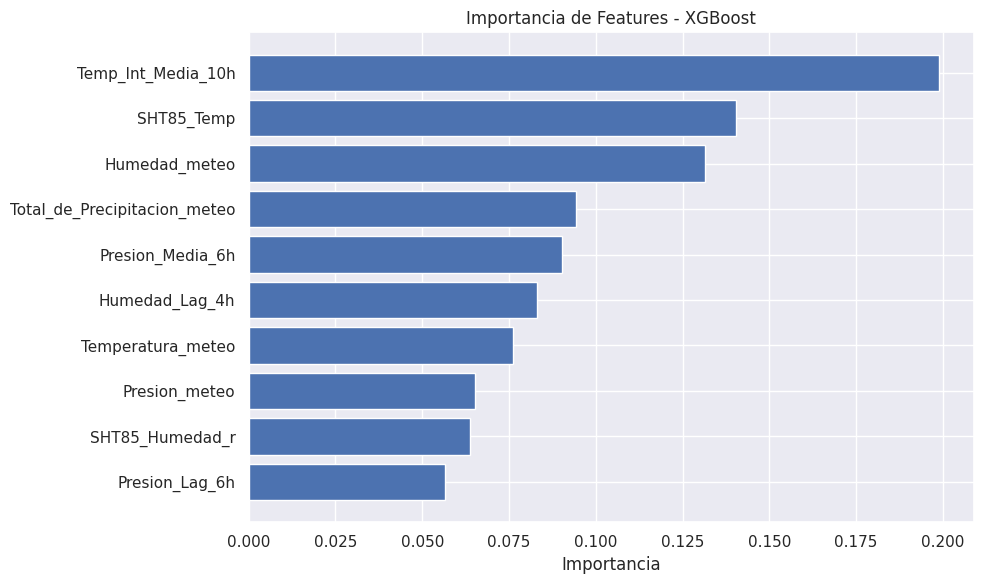

In [47]:
# Entrenar el mejor modelo XGBoost 1h
horizonte = 6  # 1h

df_temp = df_modelo_a2.copy()
df_temp['radon_futuro'] = df_temp['radon_airthings'].shift(-horizonte)
df_temp = df_temp.dropna()

X = df_temp[features_mas_reducidas]
y = df_temp['radon_futuro']

split_idx = int(len(X) * 0.8)
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

modelo_xgb =  XGBRegressor(
        n_estimators=150,
        max_depth=4,              # Intermedio
        learning_rate=0.03,       # Intermedio
        min_child_weight=10,
        reg_alpha=1,              # Moderada
        reg_lambda=3,             # Moderada
        subsample=0.7,
        colsample_bytree=0.7,
        random_state=42
    )
modelo_xgb.fit(X_train, y_train)

# Importancia de features
importancia = pd.DataFrame({
    'feature': features_mas_reducidas,
    'importancia': modelo_xgb.feature_importances_
}).sort_values('importancia', ascending=False)

print("Importancia de features:")
print(importancia.to_string(index=False))

# Gráfico
plt.figure(figsize=(10, 6))
plt.barh(importancia['feature'], importancia['importancia'])
plt.xlabel('Importancia')
plt.title('Importancia de Features - XGBoost')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

**Probar con las variables con mayor correlación con el radón**

In [48]:
# Features mínimas basadas en correlaciones más altas
features_minimas = [
    # Arduino
    'SHT85_Humedad_r',      # -0.44
    'SHT85_Temp',           # 0.38

    # Meteo
    'Total_de_Precipitacion_meteo',  # -0.38
    'Presion_meteo',        # 0.35
    'Temperatura_meteo',

    # Lags óptimos
    'Humedad_Lag_4h',
    'Presion_Lag_6h',

    # Una feature derivada
    'Temp_Int_Media_10h',

    # Temporales (mínimas)
    'Hora_Sin',
    'Hora_Cos'
]

print(f"Features: {len(features_minimas)}")



Features: 10


In [49]:
modelos_intermedio = {
    'RandomForest': RandomForestRegressor(
        n_estimators=150,
        max_depth=4,              # Intermedio
        min_samples_leaf=10,      # Intermedio
        min_samples_split=15,
        max_features='sqrt',
        random_state=42
    ),
    'XGBoost': XGBRegressor(
        n_estimators=150,
        max_depth=4,              # Intermedio
        learning_rate=0.03,       # Intermedio
        min_child_weight=10,
        reg_alpha=1,              # Moderada
        reg_lambda=3,             # Moderada
        subsample=0.7,
        colsample_bytree=0.7,
        random_state=42
    ),
    'LightGBM': LGBMRegressor(
        n_estimators=150,
        max_depth=4,              # Intermedio
        learning_rate=0.03,       # Intermedio
        min_child_samples=30,     # Intermedio
        reg_alpha=1,
        reg_lambda=3,
        subsample=0.7,
        colsample_bytree=0.7,
        random_state=42,
        verbose=-1
    )
}

# Probar todos los horizontes
horizontes = {'30min': 3, '1h': 6, '2h': 12, '3h': 18}

resultados = []

for nombre_h, horizonte in horizontes.items():
    df_temp = df_modelo_a2.copy()
    df_temp['radon_futuro'] = df_temp['radon_airthings'].shift(-horizonte)
    df_temp = df_temp.dropna()

    X = df_temp[features_minimas]
    y = df_temp['radon_futuro']

    split_idx = int(len(X) * 0.8)
    X_train, X_test = X[:split_idx], X[split_idx:]
    y_train, y_test = y[:split_idx], y[split_idx:]

    for nombre_m, modelo in modelos_intermedio.items():
        modelo_clone = modelo.__class__(**modelo.get_params())
        modelo_clone.fit(X_train, y_train)

        r2_train = r2_score(y_train, modelo_clone.predict(X_train))
        r2_test = r2_score(y_test, modelo_clone.predict(X_test))
        mae_test = mean_absolute_error(y_test, modelo_clone.predict(X_test))

        resultados.append({
            'horizonte': nombre_h,
            'modelo': nombre_m,
            'R2_train': r2_train,
            'R2_test': r2_test,
            'Overfit': r2_train - r2_test,
            'MAE_test': mae_test,
        })

df_res = pd.DataFrame(resultados)
print("\nResultados regularización intermedia:")
print("="*70)
print(df_res.sort_values('R2_test', ascending=False).head(10).to_string(index=False))


Resultados regularización intermedia:
horizonte       modelo  R2_train  R2_test  Overfit  MAE_test
    30min     LightGBM  0.756032 0.473066 0.282966 28.912322
       1h      XGBoost  0.771226 0.455103 0.316123 30.016640
       1h     LightGBM  0.754001 0.451111 0.302890 29.509080
       2h     LightGBM  0.743517 0.442616 0.300902 31.708332
    30min      XGBoost  0.775023 0.441595 0.333428 29.892739
       3h     LightGBM  0.745075 0.420998 0.324077 32.960696
       3h      XGBoost  0.774700 0.401500 0.373201 33.349466
       2h      XGBoost  0.763781 0.395966 0.367815 32.135643
    30min RandomForest  0.503301 0.329628 0.173674 32.665472
       1h RandomForest  0.503102 0.321945 0.181157 32.949611


**Importancia de variables en LightGBM 30min**

Importancia de features:
                     feature  importancia
          Temp_Int_Media_10h          429
                  SHT85_Temp          269
               Presion_meteo          204
              Presion_Lag_6h          182
             SHT85_Humedad_r          174
              Humedad_Lag_4h          171
           Temperatura_meteo          147
Total_de_Precipitacion_meteo           93
                    Hora_Cos           56
                    Hora_Sin           54


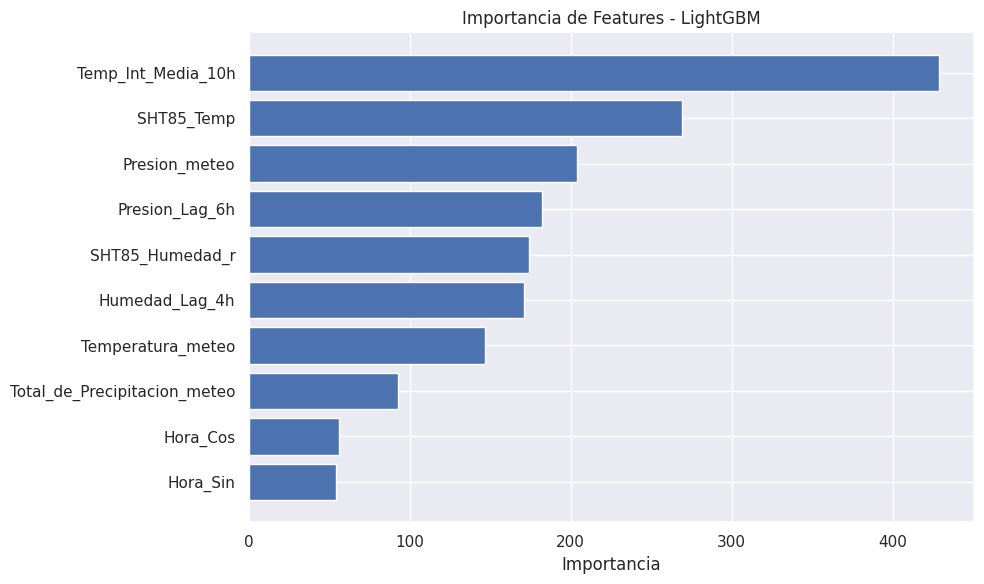

In [50]:
horizonte = 3  # 30min

df_temp = df_modelo_a2.copy()
df_temp['radon_futuro'] = df_temp['radon_airthings'].shift(-horizonte)
df_temp = df_temp.dropna()

X = df_temp[features_minimas]
y = df_temp['radon_futuro']

split_idx = int(len(X) * 0.8)
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

modelo_lgb_30m =  LGBMRegressor(
        n_estimators=150,
        max_depth=4,              # Intermedio
        learning_rate=0.03,       # Intermedio
        min_child_samples=30,     # Intermedio
        reg_alpha=1,
        reg_lambda=3,
        subsample=0.7,
        colsample_bytree=0.7,
        random_state=42,
        verbose=-1
    )
modelo_lgb_30m.fit(X_train, y_train)

# Importancia de features
importancia = pd.DataFrame({
    'feature': features_minimas,
    'importancia': modelo_lgb_30m.feature_importances_
}).sort_values('importancia', ascending=False)

print("Importancia de features:")
print(importancia.to_string(index=False))

# Gráfico
plt.figure(figsize=(10, 6))
plt.barh(importancia['feature'], importancia['importancia'])
plt.xlabel('Importancia')
plt.title('Importancia de Features - LightGBM')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [51]:
features_minimas = [
    # Arduino
    'SHT85_Humedad_r',      # -0.44
    'SHT85_Temp',           # 0.38

    # Meteo
    'Presion_meteo',        # 0.35
    'Temperatura_meteo',

    # Lags óptimos
    'Humedad_Lag_4h',
    'Presion_Lag_6h',

    # Una feature derivada
    'Temp_Int_Media_10h',
]

print(f"Features: {len(features_minimas)}")


Features: 7


In [52]:
modelos_intermedio = {
    'RandomForest': RandomForestRegressor(
        n_estimators=150,
        max_depth=4,              # Intermedio
        min_samples_leaf=10,      # Intermedio
        min_samples_split=15,
        max_features='sqrt',
        random_state=42
    ),
    'XGBoost': XGBRegressor(
        n_estimators=150,
        max_depth=4,              # Intermedio
        learning_rate=0.03,       # Intermedio
        min_child_weight=10,
        reg_alpha=1,              # Moderada
        reg_lambda=3,             # Moderada
        subsample=0.7,
        colsample_bytree=0.7,
        random_state=42
    ),
    'LightGBM': LGBMRegressor(
        n_estimators=150,
        max_depth=4,              # Intermedio
        learning_rate=0.03,       # Intermedio
        min_child_samples=30,     # Intermedio
        reg_alpha=1,
        reg_lambda=3,
        subsample=0.7,
        colsample_bytree=0.7,
        random_state=42,
        verbose=-1
    )
}

# Probar todos los horizontes
horizontes = {'30min': 3, '1h': 6, '2h': 12, '3h': 18}

resultados = []

for nombre_h, horizonte in horizontes.items():
    df_temp = df_modelo_a2.copy()
    df_temp['radon_futuro'] = df_temp['radon_airthings'].shift(-horizonte)
    df_temp = df_temp.dropna()

    X = df_temp[features_minimas]
    y = df_temp['radon_futuro']

    split_idx = int(len(X) * 0.8)
    X_train, X_test = X[:split_idx], X[split_idx:]
    y_train, y_test = y[:split_idx], y[split_idx:]

    for nombre_m, modelo in modelos_intermedio.items():
        modelo_clone = modelo.__class__(**modelo.get_params())
        modelo_clone.fit(X_train, y_train)

        r2_train = r2_score(y_train, modelo_clone.predict(X_train))
        r2_test = r2_score(y_test, modelo_clone.predict(X_test))
        mae_test = mean_absolute_error(y_test, modelo_clone.predict(X_test))

        resultados.append({
            'horizonte': nombre_h,
            'modelo': nombre_m,
            'R2_train': r2_train,
            'R2_test': r2_test,
            'Overfit': r2_train - r2_test,
            'MAE_test': mae_test,
        })

df_res = pd.DataFrame(resultados)
print("\nResultados regularización intermedia:")
print("="*70)
print(df_res.sort_values('R2_test', ascending=False).head(10).to_string(index=False))


Resultados regularización intermedia:
horizonte       modelo  R2_train  R2_test  Overfit  MAE_test
    30min     LightGBM  0.754425 0.519828 0.234597 30.507764
       2h     LightGBM  0.730834 0.489463 0.241371 31.980368
       1h     LightGBM  0.753695 0.466786 0.286909 32.171641
       3h     LightGBM  0.752527 0.448648 0.303879 33.421671
    30min      XGBoost  0.757178 0.438734 0.318445 32.960652
       1h      XGBoost  0.761976 0.423928 0.338048 33.305822
       3h      XGBoost  0.766792 0.381540 0.385252 34.971263
       2h      XGBoost  0.753696 0.376663 0.377033 34.724911
    30min RandomForest  0.507936 0.279851 0.228085 35.124332
       1h RandomForest  0.503712 0.266286 0.237426 35.527547


Parece que mejora el R2 (de 0.473 a 0.519) y el overfit (de 0.283 a 0.234)

**Calcular el sesgo**

In [53]:
# Recalcular todo de forma consistente
horizonte = 3  # 30 minutos

df_temp = df_modelo_a2.copy()
df_temp['radon_futuro'] = df_temp['radon_airthings'].shift(-horizonte)
df_temp = df_temp.dropna()

X = df_temp[features_minimas]
y = df_temp['radon_futuro']

split_idx = int(len(X) * 0.8)
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

# Verificar tamaños
print(f"X_test: {len(X_test)}, y_test: {len(y_test)}")

# Entrenar
modelo_lgbm.fit(X_train, y_train)

# Predecir
y_pred = modelo_lgbm.predict(X_test)
print(f"y_pred: {len(y_pred)}")

# Ahora sí calcular el sesgo
diferencia = y_test.values - y_pred
print(f"\nEstadísticos del error:")
print(f"  Sesgo medio: {diferencia.mean():.1f} Bq/m³")
print(f"  Std error: {diferencia.std():.1f} Bq/m³")
print(f"  Dentro de ±30 Bq/m³: {(np.abs(diferencia) <= 30).mean()*100:.1f}%")
print(f"  Dentro de ±50 Bq/m³: {(np.abs(diferencia) <= 50).mean()*100:.1f}%")

X_test: 1019, y_test: 1019
y_pred: 1019

Estadísticos del error:
  Sesgo medio: 8.2 Bq/m³
  Std error: 36.5 Bq/m³
  Dentro de ±30 Bq/m³: 50.3%
  Dentro de ±50 Bq/m³: 80.2%


El modelo tiene un sesgo de 8.2  Bq/m³, por lo que las predicciones subestiman los valores reales

**Probar ajustando parámetros**

In [54]:
# Horizonte 30min
horizonte = 3

df_temp = df_modelo_a2.copy()
df_temp['radon_futuro'] = df_temp['radon_airthings'].shift(-horizonte)
df_temp = df_temp.dropna()

X = df_temp[features_minimas]
y = df_temp['radon_futuro']

split_idx = int(len(X) * 0.8)
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

# Configuraciones a probar
configs = {
    'Actual': {
        'max_depth': 4, 'num_leaves': 31, 'min_child_samples': 30,
        'reg_alpha': 1, 'reg_lambda': 3, 'learning_rate': 0.03
    },
    'Menos profundo': {
        'max_depth': 3, 'num_leaves': 8, 'min_child_samples': 20,
        'reg_alpha': 1, 'reg_lambda': 3, 'learning_rate': 0.03
    },
    'Más muestras hoja': {
        'max_depth': 4, 'num_leaves': 15, 'min_child_samples': 40,
        'reg_alpha': 1, 'reg_lambda': 3, 'learning_rate': 0.03
    },
    'Más regularización': {
        'max_depth': 4, 'num_leaves': 15, 'min_child_samples': 20,
        'reg_alpha': 3, 'reg_lambda': 8, 'learning_rate': 0.03
    },
    'Learning rate bajo': {
        'max_depth': 4, 'num_leaves': 15, 'min_child_samples': 20,
        'reg_alpha': 1, 'reg_lambda': 3, 'learning_rate': 0.01
    },
    'Combinado': {
        'max_depth': 3, 'num_leaves': 8, 'min_child_samples': 30,
        'reg_alpha': 2, 'reg_lambda': 5, 'learning_rate': 0.02
    }
}

print("Comparativa de configuraciones:")
print("="*80)

resultados = []
for nombre, params in configs.items():
    modelo = LGBMRegressor(
        n_estimators=150,
        subsample=0.7,
        colsample_bytree=0.7,
        random_state=42,
        verbose=-1,
        **params
    )

    modelo.fit(X_train, y_train)

    r2_train = r2_score(y_train, modelo.predict(X_train))
    r2_test = r2_score(y_test, modelo.predict(X_test))
    mae_test = mean_absolute_error(y_test, modelo.predict(X_test))

    resultados.append({
        'Config': nombre,
        'R2_train': r2_train,
        'R2_test': r2_test,
        'Overfit': r2_train - r2_test,
        'MAE': mae_test
    })

    print(f"{nombre:20} | R² Train: {r2_train:.3f} | R² Test: {r2_test:.3f} | Overfit: {r2_train-r2_test:.3f} | MAE: {mae_test:.1f}")

# Mejor configuración
df_res = pd.DataFrame(resultados)
mejor = df_res.loc[df_res['Overfit'].idxmin()]
print(f"\n→ Menor overfit: {mejor['Config']}")
mejor = df_res.loc[df_res['R2_test'].idxmax()]
print(f"→ Mayor R² test: {mejor['Config']}")

Comparativa de configuraciones:
Actual               | R² Train: 0.754 | R² Test: 0.520 | Overfit: 0.235 | MAE: 30.5
Menos profundo       | R² Train: 0.635 | R² Test: 0.477 | Overfit: 0.158 | MAE: 30.7
Más muestras hoja    | R² Train: 0.745 | R² Test: 0.477 | Overfit: 0.268 | MAE: 31.8
Más regularización   | R² Train: 0.745 | R² Test: 0.459 | Overfit: 0.287 | MAE: 31.9
Learning rate bajo   | R² Train: 0.560 | R² Test: 0.238 | Overfit: 0.322 | MAE: 35.6
Combinado            | R² Train: 0.566 | R² Test: 0.419 | Overfit: 0.147 | MAE: 32.2

→ Menor overfit: Combinado
→ Mayor R² test: Actual


**Parece que el modelo no se puede mejorar.**